In [137]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [138]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

## Image to Tensor Conversions

In [287]:
imsize = 256

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [396]:
set_folder = "Set3"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [397]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [298]:
device = torch.device("cuda")
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [263]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [264]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [265]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [266]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [273]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

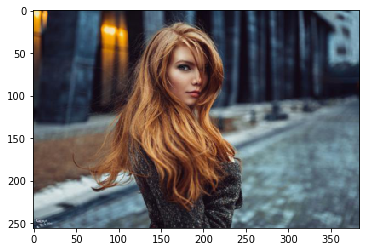

In [398]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [399]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.01)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

Iteration 1:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000023  Content Loss = 0.006808 
Iteration 1:  Style Loss = 0.000022  Content Loss = 0.010419 
Iteration 1:  Style Loss = 0.000021  Content Loss = 0.017272 
Iteration 1:  Style Loss = 0.000019  Content Loss = 0.024010 
Iteration 1:  Style Loss = 0.000018  Content Loss = 0.029800 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.034559 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.038842 
Iteration 1:  Style Loss = 0.000015  Content Loss = 0.042784 
Iteration 1:  Style Loss = 0.000014  Content Loss = 0.046433 
Iteration 1:  Style Loss = 0.000013  Content Loss = 0.049810 
Iteration 1:  Style Loss = 0.000013  Content Loss = 0.052996 
Iteration 1:  Style Loss = 0.000012  Content Loss = 0.055982 
Iteration 1:  Style Loss = 0.000012  Content Loss = 0.058755 
Iteratio

Iteration 7:  Style Loss = 0.000001  Content Loss = 0.148644 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.148857 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.149064 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.149270 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.149472 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.149673 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.149869 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.150062 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.150251 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.150438 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.150623 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.150804 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.150981 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.151155 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.151325 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.151493 
Iteratio

Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159632 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159646 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159658 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159671 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159683 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159694 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159704 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159715 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159725 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159734 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159743 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159751 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159759 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.159766 
Iteration 15:  Style Loss = 0.000000  Content Loss = 0.159773 
Iteration 15:  Style Loss = 0.000000  Content Loss = 0.

Iteration 20:  Style Loss = 0.000000  Content Loss = 0.157500 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.157457 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157416 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157368 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157322 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157278 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157235 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157190 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157146 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157103 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157056 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.157010 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.156965 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.156917 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.156870 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.

Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150397 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150346 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150297 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150249 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150200 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150152 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150104 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150057 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.150010 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.149961 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.149917 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.149871 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.149825 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.149782 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.149741 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.

Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146481 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146462 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146442 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146424 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146405 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146385 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146367 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146348 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146327 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146309 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146289 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146269 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146249 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146229 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.146211 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.

Iteration 40:  Style Loss = 0.000000  Content Loss = 0.143856 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.143837 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.143819 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.143799 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.143781 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.143761 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143742 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143724 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143706 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143689 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143669 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143651 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143633 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143615 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.143597 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.

Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141486 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141470 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141453 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141434 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141417 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141402 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141387 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141370 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141354 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141340 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141325 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141309 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141294 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.141279 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.141265 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.

Iteration 53:  Style Loss = 0.000000  Content Loss = 0.141135 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.141135 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141135 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141135 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141134 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141133 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141132 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141131 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141129 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141128 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141126 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141124 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141121 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141119 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.141116 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.

Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139739 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139723 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139706 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139689 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139673 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139655 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139639 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139622 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139604 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.139586 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.139568 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.139549 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.139531 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.139513 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.139496 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.

Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137301 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137285 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137271 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137255 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137240 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137226 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137211 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137197 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137183 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137170 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137155 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137141 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137128 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137115 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.137100 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.

Iteration 73:  Style Loss = 0.000000  Content Loss = 0.136089 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.136085 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.136080 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.136075 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.136070 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.136065 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136061 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136056 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136052 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136047 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136043 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136038 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136034 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136029 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.136025 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.

Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135942 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135946 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135951 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135956 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135960 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135965 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135969 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135975 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135980 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135984 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135989 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.135995 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.136000 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.136006 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.136011 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.

Iteration 86:  Style Loss = 0.000000  Content Loss = 0.136862 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.136868 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136873 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136879 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136885 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136889 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136895 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136900 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136905 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136910 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136914 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136919 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136923 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136928 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.136932 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.

Iteration 93:  Style Loss = 0.000000  Content Loss = 0.137016 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.137013 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.137010 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.137007 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.137004 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.137001 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.136997 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.136993 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.136990 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.136987 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.136983 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.136979 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.136976 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.136972 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.136968 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.

Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136127 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136118 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136110 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136100 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136090 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136081 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136072 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136062 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136053 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136043 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136032 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136023 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136014 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.136004 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.135994 
Iteration 100:  Style Loss = 0.000000  C

Iteration 106:  Style Loss = 0.000000  Content Loss = 0.134822 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.134813 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.134805 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.134795 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.134785 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.134776 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.134766 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.134758 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.134748 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.134739 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.134730 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.134722 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.134713 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.134704 
Iteration 108:  Style Loss = 0.000000  Content Loss = 0.134704 
Iteration 108:  Style Loss = 0.000000  C

Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134742 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134755 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134767 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134781 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134793 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134807 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134821 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134833 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134848 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134861 
Iteration 116:  Style Loss = 0.000000  Content Loss = 0.134875 
Iteration 117:  Style Loss = 0.000000  Content Loss = 0.134889 
Iteration 117:  Style Loss = 0.000000  Content Loss = 0.134903 
Iteration 117:  Style Loss = 0.000000  Content Loss = 0.134917 
Iteration 117:  Style Loss = 0.000000  Content Loss = 0.134931 
Iteration 117:  Style Loss = 0.000000  C

Iteration 122:  Style Loss = 0.000000  Content Loss = 0.136306 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136312 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136317 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136322 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136327 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136332 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136337 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136342 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136347 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136351 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136356 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136360 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136364 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136368 
Iteration 123:  Style Loss = 0.000000  Content Loss = 0.136372 
Iteration 123:  Style Loss = 0.000000  C

Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136230 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136225 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136220 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136215 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136210 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136205 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136200 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136195 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136189 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136184 
Iteration 129:  Style Loss = 0.000000  Content Loss = 0.136179 
Iteration 130:  Style Loss = 0.000000  Content Loss = 0.136174 
Iteration 130:  Style Loss = 0.000000  Content Loss = 0.136169 
Iteration 130:  Style Loss = 0.000000  Content Loss = 0.136163 
Iteration 130:  Style Loss = 0.000000  Content Loss = 0.136158 
Iteration 130:  Style Loss = 0.000000  C

Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135367 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135359 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135351 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135342 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135334 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135326 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135317 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135308 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135299 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135290 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135282 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135273 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135263 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135254 
Iteration 136:  Style Loss = 0.000000  Content Loss = 0.135245 
Iteration 136:  Style Loss = 0.000000  C

Iteration 142:  Style Loss = 0.000000  Content Loss = 0.134299 
Iteration 142:  Style Loss = 0.000000  Content Loss = 0.134299 
Iteration 142:  Style Loss = 0.000000  Content Loss = 0.134300 
Iteration 142:  Style Loss = 0.000000  Content Loss = 0.134301 
Iteration 142:  Style Loss = 0.000000  Content Loss = 0.134302 
Iteration 142:  Style Loss = 0.000000  Content Loss = 0.134303 
Iteration 142:  Style Loss = 0.000000  Content Loss = 0.134305 
Iteration 142:  Style Loss = 0.000000  Content Loss = 0.134308 
Iteration 143:  Style Loss = 0.000000  Content Loss = 0.134311 
Iteration 143:  Style Loss = 0.000000  Content Loss = 0.134314 
Iteration 143:  Style Loss = 0.000000  Content Loss = 0.134318 
Iteration 143:  Style Loss = 0.000000  Content Loss = 0.134322 
Iteration 143:  Style Loss = 0.000000  Content Loss = 0.134327 
Iteration 143:  Style Loss = 0.000000  Content Loss = 0.134333 
Iteration 143:  Style Loss = 0.000000  Content Loss = 0.134339 
Iteration 143:  Style Loss = 0.000000  C

Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136437 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136443 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136449 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136454 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136459 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136464 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136468 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136472 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136475 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136478 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136481 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136483 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136484 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136486 
Iteration 149:  Style Loss = 0.000000  Content Loss = 0.136487 
Iteration 149:  Style Loss = 0.000000  C

Iteration 155:  Style Loss = 0.000000  Content Loss = 0.135265 
Iteration 155:  Style Loss = 0.000000  Content Loss = 0.135250 
Iteration 155:  Style Loss = 0.000000  Content Loss = 0.135234 
Iteration 155:  Style Loss = 0.000000  Content Loss = 0.135220 
Iteration 155:  Style Loss = 0.000000  Content Loss = 0.135204 
Iteration 155:  Style Loss = 0.000000  Content Loss = 0.135188 
Iteration 155:  Style Loss = 0.000000  Content Loss = 0.135173 
Iteration 155:  Style Loss = 0.000000  Content Loss = 0.135156 
Iteration 156:  Style Loss = 0.000000  Content Loss = 0.135140 
Iteration 156:  Style Loss = 0.000000  Content Loss = 0.135124 
Iteration 156:  Style Loss = 0.000000  Content Loss = 0.135107 
Iteration 156:  Style Loss = 0.000000  Content Loss = 0.135091 
Iteration 156:  Style Loss = 0.000000  Content Loss = 0.135076 
Iteration 156:  Style Loss = 0.000000  Content Loss = 0.135061 
Iteration 156:  Style Loss = 0.000000  Content Loss = 0.135045 
Iteration 156:  Style Loss = 0.000000  C

Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133449 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133437 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133425 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133413 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133402 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133390 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133377 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133366 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133355 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133342 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133331 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133319 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133307 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133296 
Iteration 162:  Style Loss = 0.000000  Content Loss = 0.133284 
Iteration 162:  Style Loss = 0.000000  C

Iteration 168:  Style Loss = 0.000000  Content Loss = 0.132092 
Iteration 168:  Style Loss = 0.000000  Content Loss = 0.132086 
Iteration 168:  Style Loss = 0.000000  Content Loss = 0.132080 
Iteration 168:  Style Loss = 0.000000  Content Loss = 0.132074 
Iteration 168:  Style Loss = 0.000000  Content Loss = 0.132069 
Iteration 168:  Style Loss = 0.000000  Content Loss = 0.132064 
Iteration 168:  Style Loss = 0.000000  Content Loss = 0.132059 
Iteration 168:  Style Loss = 0.000000  Content Loss = 0.132053 
Iteration 169:  Style Loss = 0.000000  Content Loss = 0.132048 
Iteration 169:  Style Loss = 0.000000  Content Loss = 0.132043 
Iteration 169:  Style Loss = 0.000000  Content Loss = 0.132038 
Iteration 169:  Style Loss = 0.000000  Content Loss = 0.132033 
Iteration 169:  Style Loss = 0.000000  Content Loss = 0.132029 
Iteration 169:  Style Loss = 0.000000  Content Loss = 0.132024 
Iteration 169:  Style Loss = 0.000000  Content Loss = 0.132020 
Iteration 169:  Style Loss = 0.000000  C

Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132045 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132046 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132046 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132047 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132047 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132048 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132048 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132048 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132049 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132049 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132049 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132050 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132050 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132050 
Iteration 175:  Style Loss = 0.000000  Content Loss = 0.132050 
Iteration 175:  Style Loss = 0.000000  C

Iteration 181:  Style Loss = 0.000000  Content Loss = 0.131905 
Iteration 181:  Style Loss = 0.000000  Content Loss = 0.131903 
Iteration 181:  Style Loss = 0.000000  Content Loss = 0.131900 
Iteration 181:  Style Loss = 0.000000  Content Loss = 0.131898 
Iteration 181:  Style Loss = 0.000000  Content Loss = 0.131896 
Iteration 181:  Style Loss = 0.000000  Content Loss = 0.131894 
Iteration 181:  Style Loss = 0.000000  Content Loss = 0.131892 
Iteration 181:  Style Loss = 0.000000  Content Loss = 0.131890 
Iteration 182:  Style Loss = 0.000000  Content Loss = 0.131888 
Iteration 182:  Style Loss = 0.000000  Content Loss = 0.131886 
Iteration 182:  Style Loss = 0.000000  Content Loss = 0.131884 
Iteration 182:  Style Loss = 0.000000  Content Loss = 0.131882 
Iteration 182:  Style Loss = 0.000000  Content Loss = 0.131880 
Iteration 182:  Style Loss = 0.000000  Content Loss = 0.131877 
Iteration 182:  Style Loss = 0.000000  Content Loss = 0.131875 
Iteration 182:  Style Loss = 0.000000  C

Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131602 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131599 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131597 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131594 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131591 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131588 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131585 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131582 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131579 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131576 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131573 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131570 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131568 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131564 
Iteration 188:  Style Loss = 0.000000  Content Loss = 0.131561 
Iteration 188:  Style Loss = 0.000000  C

Iteration 194:  Style Loss = 0.000000  Content Loss = 0.131109 
Iteration 194:  Style Loss = 0.000000  Content Loss = 0.131104 
Iteration 194:  Style Loss = 0.000000  Content Loss = 0.131099 
Iteration 194:  Style Loss = 0.000000  Content Loss = 0.131095 
Iteration 194:  Style Loss = 0.000000  Content Loss = 0.131090 
Iteration 194:  Style Loss = 0.000000  Content Loss = 0.131085 
Iteration 194:  Style Loss = 0.000000  Content Loss = 0.131081 
Iteration 194:  Style Loss = 0.000000  Content Loss = 0.131076 
Iteration 195:  Style Loss = 0.000000  Content Loss = 0.131072 
Iteration 195:  Style Loss = 0.000000  Content Loss = 0.131068 
Iteration 195:  Style Loss = 0.000000  Content Loss = 0.131063 
Iteration 195:  Style Loss = 0.000000  Content Loss = 0.131058 
Iteration 195:  Style Loss = 0.000000  Content Loss = 0.131053 
Iteration 195:  Style Loss = 0.000000  Content Loss = 0.131048 
Iteration 195:  Style Loss = 0.000000  Content Loss = 0.131043 
Iteration 195:  Style Loss = 0.000000  C

Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130598 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130596 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130595 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130594 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130593 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130592 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130591 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130590 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130589 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130588 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130587 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130587 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130586 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130586 
Iteration 201:  Style Loss = 0.000000  Content Loss = 0.130585 
Iteration 201:  Style Loss = 0.000000  C

Iteration 207:  Style Loss = 0.000000  Content Loss = 0.130910 
Iteration 207:  Style Loss = 0.000000  Content Loss = 0.130915 
Iteration 207:  Style Loss = 0.000000  Content Loss = 0.130919 
Iteration 207:  Style Loss = 0.000000  Content Loss = 0.130923 
Iteration 207:  Style Loss = 0.000000  Content Loss = 0.130927 
Iteration 207:  Style Loss = 0.000000  Content Loss = 0.130931 
Iteration 207:  Style Loss = 0.000000  Content Loss = 0.130936 
Iteration 207:  Style Loss = 0.000000  Content Loss = 0.130940 
Iteration 208:  Style Loss = 0.000000  Content Loss = 0.130944 
Iteration 208:  Style Loss = 0.000000  Content Loss = 0.130949 
Iteration 208:  Style Loss = 0.000000  Content Loss = 0.130953 
Iteration 208:  Style Loss = 0.000000  Content Loss = 0.130958 
Iteration 208:  Style Loss = 0.000000  Content Loss = 0.130962 
Iteration 208:  Style Loss = 0.000000  Content Loss = 0.130966 
Iteration 208:  Style Loss = 0.000000  Content Loss = 0.130970 
Iteration 208:  Style Loss = 0.000000  C

Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131334 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131335 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131337 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131338 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131339 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131341 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131342 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131343 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131345 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131346 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131347 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131348 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131349 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131350 
Iteration 214:  Style Loss = 0.000000  Content Loss = 0.131351 
Iteration 214:  Style Loss = 0.000000  C

Iteration 220:  Style Loss = 0.000000  Content Loss = 0.131212 
Iteration 220:  Style Loss = 0.000000  Content Loss = 0.131208 
Iteration 220:  Style Loss = 0.000000  Content Loss = 0.131205 
Iteration 220:  Style Loss = 0.000000  Content Loss = 0.131201 
Iteration 220:  Style Loss = 0.000000  Content Loss = 0.131198 
Iteration 220:  Style Loss = 0.000000  Content Loss = 0.131194 
Iteration 220:  Style Loss = 0.000000  Content Loss = 0.131190 
Iteration 220:  Style Loss = 0.000000  Content Loss = 0.131186 
Iteration 221:  Style Loss = 0.000000  Content Loss = 0.131182 
Iteration 221:  Style Loss = 0.000000  Content Loss = 0.131178 
Iteration 221:  Style Loss = 0.000000  Content Loss = 0.131174 
Iteration 221:  Style Loss = 0.000000  Content Loss = 0.131170 
Iteration 221:  Style Loss = 0.000000  Content Loss = 0.131166 
Iteration 221:  Style Loss = 0.000000  Content Loss = 0.131163 
Iteration 221:  Style Loss = 0.000000  Content Loss = 0.131159 
Iteration 221:  Style Loss = 0.000000  C

Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130563 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130557 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130551 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130544 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130538 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130532 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130527 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130521 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130514 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130508 
Iteration 227:  Style Loss = 0.000000  Content Loss = 0.130502 
Iteration 228:  Style Loss = 0.000000  Content Loss = 0.130502 
Iteration 228:  Style Loss = 0.000000  Content Loss = 0.130496 
Iteration 228:  Style Loss = 0.000000  Content Loss = 0.130490 
Iteration 228:  Style Loss = 0.000000  Content Loss = 0.130483 
Iteration 229:  Style Loss = 0.000000  C

Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129914 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129912 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129910 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129908 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129906 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129904 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129903 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129901 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129900 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129898 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129897 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129896 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129895 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129894 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.129893 
Iteration 236:  Style Loss = 0.000000  C

Iteration 242:  Style Loss = 0.000000  Content Loss = 0.130512 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.130520 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.130531 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.130539 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.130548 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.130557 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.130566 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.130575 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.130585 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.130593 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.130602 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.130612 
Iteration 244:  Style Loss = 0.000000  Content Loss = 0.130612 
Iteration 244:  Style Loss = 0.000000  Content Loss = 0.130621 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.130621 
Iteration 245:  Style Loss = 0.000000  C

Iteration 250:  Style Loss = 0.000000  Content Loss = 0.131378 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.131381 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.131384 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.131388 


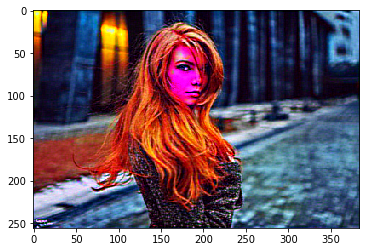

In [400]:
output = style_transfer(vgg, content, style, input_img, iters=250, style_w=1000000, content_w=10)
output.save("UpdatedSets/"+set_folder+"/output.png")